This implementation is heavily influenced by Eu Jin Lok: https://www.kaggle.com/ejlok1.
The code that I implememted has been highlighted

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import json
import pickle
import time

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torchaudio
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import numpy as np
import pandas as pd

import glob
import librosa
import librosa.display
import IPython.display as ipd

    

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
import os

In [ ]:
TransformedClassLabels = ['female_angry', 'female_disgust', 'female_fear', 'female_happy',
 'female_neutral', 'female_sad', 'female_surprise', 'male_angry',
 'male_disgust', 'male_fear', 'male_happy', 'male_neutral', 'male_sad',
 'male_surprise']
print(TransformedClassLabels)

In [0]:
RAV = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
dirList = os.listdir(RAV)
dirList.sort()
#print(dirList[0:50])

emotion = []
gender = []
pathList = []
for i in dirList:
  fname = os.listdir(RAV + i)
  for f in fname:
    part = f.split('.')[0].split('-')
    emotion.append(int(part[2]))
    temp = int(part[6])
    if temp%2 == 0:
        temp = "female"
    else:
        temp = "male"
    gender.append(temp)
    pathList.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(pathList, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

Shape of waveform (76517,)
Sampling Rate: 22050


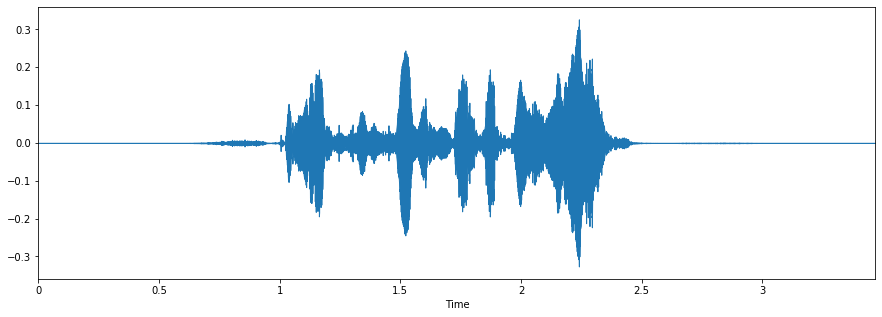

In [0]:
# Comparing audio between Fearful and Happy - Following is Fearful
fnameFemaleFear = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fnameFemaleFear)
print("Shape of waveform {}".format(data.shape))
print("Sampling Rate: {}".format(sampling_rate))
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
#plt.plot(data.t().numpy())

ipd.Audio(fnameFemaleFear) #To listen to audio in the notebook

The following code was my implementation

Shape of waveform (82403,)
Sampling Rate: 22050


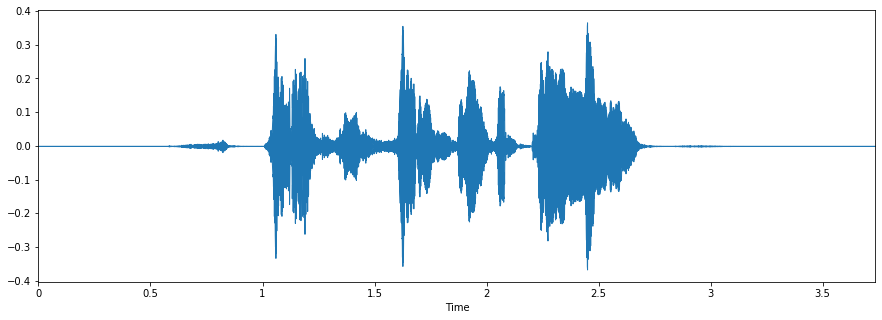

In [0]:
# Comparing audio between Fearful and Happy from same person- Following is Happy
fnameFemaleHappy = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fnameFemaleHappy)
print("Shape of waveform {}".format(data.shape))
print("Sampling Rate: {}".format(sampling_rate))
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fnameFemaleHappy) #To listen to audio in the notebook

Shape of waveform (71367,)
Sampling Rate: 22050


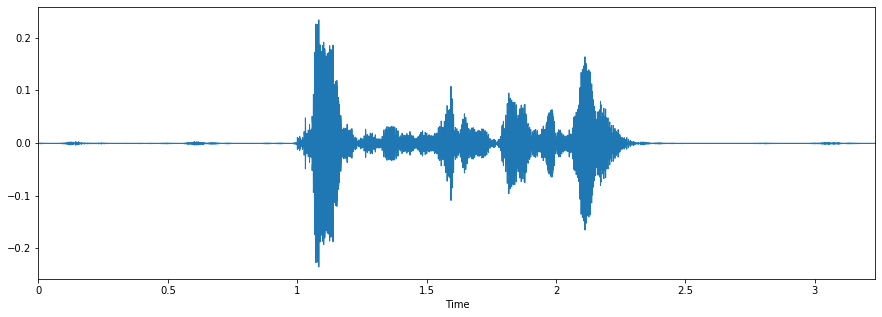

In [0]:
# Comparing audio between Fearful and Happy from same person- Following is Happy
fnameMaleFear = RAV + 'Actor_09/03-01-06-02-02-02-09.wav'  
data, sampling_rate = librosa.load(fnameMaleFear)
print("Shape of waveform {}".format(data.shape))
print("Sampling Rate: {}".format(sampling_rate))
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fnameMaleFear) #To listen to audio in the notebook

Shape of waveform (78724,)
Sampling Rate: 22050


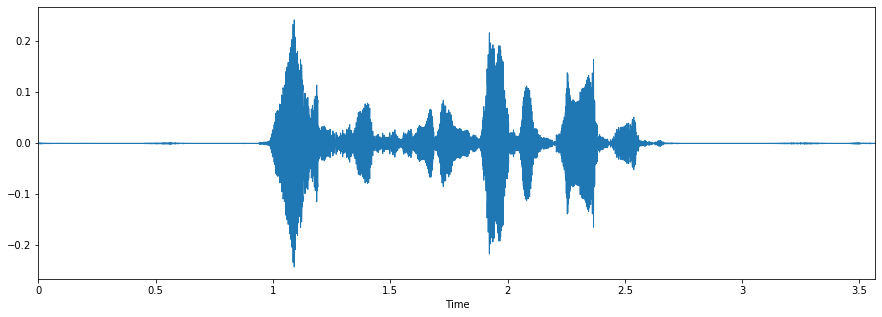

In [0]:
# Comparing audio between Fearful and Happy - Following is Fearful
fnameMaleHappy = RAV + 'Actor_09/03-01-03-02-02-02-09.wav'  
data, sampling_rate = librosa.load(fnameMaleHappy)
print("Shape of waveform {}".format(data.shape))
print("Sampling Rate: {}".format(sampling_rate))
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fnameMaleHappy) #To listen to audio in the notebook

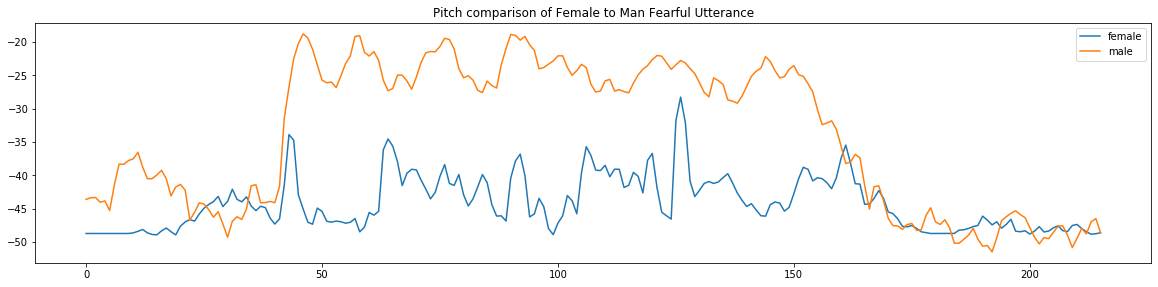

In [0]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
#Actor_14/03-01-06-02-02-02-14.wav
path = "/content/drive/My Drive/Google_CoLab/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-06-02-02-02-14.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/drive/My Drive/Google_CoLab/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-06-02-02-02-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.title("Pitch comparison of Female to Man Fearful Utterance")
plt.legend()

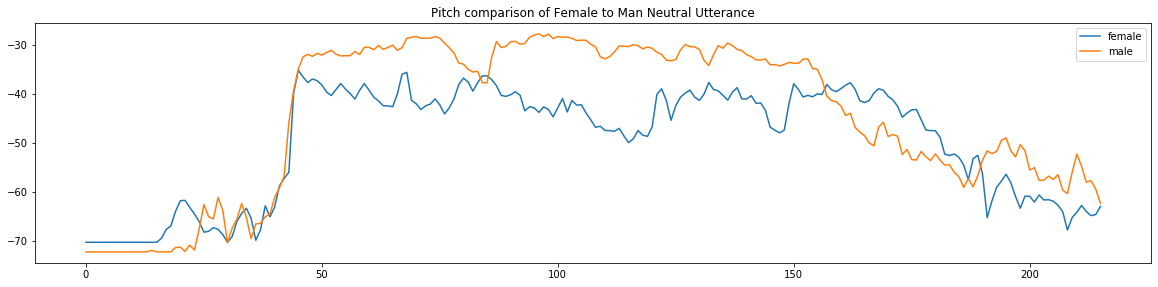

In [0]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
#Actor_14/03-01-06-02-02-02-14.wav
path = "/content/drive/My Drive/Google_CoLab/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-01-01-02-02-14.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/drive/My Drive/Google_CoLab/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-01-01-02-02-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.title("Pitch comparison of Female to Man Neutral Utterance")
plt.legend()

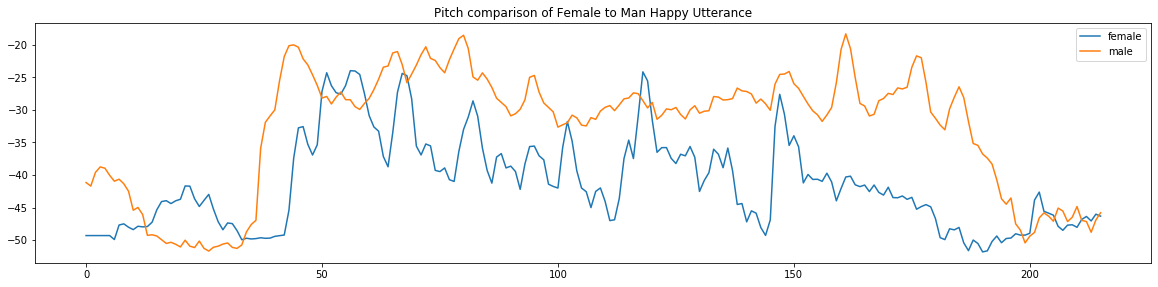

In [0]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
#Actor_14/03-01-06-02-02-02-14.wav
path = "/content/drive/My Drive/Google_CoLab/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-03-02-02-02-14.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/content/drive/My Drive/Google_CoLab/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-03-02-02-02-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.title("Pitch comparison of Female to Man Happy Utterance")
plt.legend()

In [0]:
# import tensorflow as tf
# #tf.test.gpu_device_name()
# from tensorflow.python.client import device_lib
# #device_lib.list_local_devices()
# !cat /proc/cpuinfo
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



My implementation ends here, Lok's work continues

In [0]:
counter=0
start = time.time()
df = pd.DataFrame(columns=['feature'])

for index,path in enumerate(pathList):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()
endTime = time.time()
print("It took: {}".format(endTime - start))

1440
It took: 847.7516715526581


In [0]:
#df.to_csv("exportedEmoFile.csv", index=False)
ref = RAV_df
Consoldf = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
#display(Consoldf[:5])
#print(Consoldf.shape)

Consoldf = Consoldf.fillna(0)
#print(Consoldf.shape)
Consoldf.to_csv("/content/drive/My Drive/Google_CoLab/exportedEmoFile.csv", index=False)
display(Consoldf[:5])

,labels,source,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,...,-59.615328,-56.169903,-57.875562,-61.149496,-62.058126,-58.724914,-56.277627,-58.083108,-60.733636,-62.754215,-63.549244,-64.526266,-65.800971,-65.771172,-62.390423,-60.171205,-61.831569,-64.845866,-64.133097,-63.383669,-61.310815,-60.995465,-62.350353,-62.845241,-60.302466,-58.946521,-59.711816,-56.837098,-56.425769,-56.877954,-58.299903,-62.295248,-64.930130,-65.332128,-64.116934,-64.319911,-64.971422,-63.155779,-64.178668,-63.061902
1,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-61.849949,-62.895033,-63.830647,-60.552590,-60.821684,-62.073396,-64.889228,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-63.679656,-59.562475,-59.068306,-62.143033,-62.431462,-64.841821,-65.389948,-65.389948,-63.869841,-61.360492,-59.707017,-59.798056,-62.271154,-60.549896,-58.221012,-58.358541,-60.648374,-53.253787,-51.222221,-49.679046,-51.875681,-56.024106,-57.659168,-58.432061,-58.607403,...,-53.208478,-54.152441,-52.782883,-53.128404,-57.195379,-55.770453,-55.109805,-57.923445,-56.826748,-57.972347,-56.143225,-53.263351,-55.030139,-58.031881,-62.373600,-63.339109,-59.324894,-58.807633,-62.784229,-63.298385,-63.522439,-64.283955,-64.732161,-61.390440,-60.565392,-61.248813,-64.317986,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948
2,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-65.818869,-65.818869,-65.818869,-65.818869,-65.805538,-65.818869,-65.818869,-65.629539,-64.802625,-65.818869,-65.818869,-65.818869,-65.818869,-65.108404,-65.818869,-65.818869,-65.818869,-65.261425,-65.123928,-65.818869,-64.191042,-61.744355,-61.067486,-61.839816,-65.328680,-65.211158,-65.663178,-65.818869,-65.818869,-65.816125,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.470501,-62.254325,...,-58.574695,-59.631354,-60.101534,-58.546990,-59.596250,-61.501059,-59.898731,-61.415549,-63.316846,-62.846409,-61.955321,-65.802359,-62.626907,-59.936369,-61.786325,-65.818869,-65.189666,-65.818869,-65.818869,-65.818869,-65.522793,-65.663626,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.438060,-65.684853,-65.818869,-65.818869,-65.818869,-65.818869
3,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-65.682145,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-65.750829,-63.380211,-62.699950,-65.097628,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.002158,-61.924173,-59.584440,...,-55.763687,-58.544620,-55.987887,-56.974609,-61.779677,-65.383069,-63.934941,-63.327847,-62.010690,-61.250412,-62.366334,-62.562523,-61.351269,-63.538979,-64.852010,-61.058000,-60.733821,-62.970143,-65.924813,-66.058485,-66.058485,-65.232852,-64.616167,-65.550135,-66.058485,-66.058485,-65.295684,-61.710804,-60.359995,-60.372977,-57.539617,-55.826307,-57.741989,-59.796385,-60.975377,-62.663056,-64.573480,-63.782612,-61.515785,-58.214885
4,male_happy,RAVDES

In [0]:
Consoldf_test = pd.read_csv("/content/drive/My Drive/Google_CoLab/exportedEmoFile.csv")
display(Consoldf_test)

,labels,source,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,...,-59.615328,-56.169903,-57.875562,-61.149496,-62.058126,-58.724914,-56.277627,-58.083108,-60.733636,-62.754215,-63.549244,-64.526266,-65.800971,-65.771172,-62.390423,-60.171205,-61.831569,-64.845866,-64.133097,-63.383669,-61.310815,-60.995465,-62.350353,-62.845241,-60.302466,-58.946521,-59.711816,-56.837098,-56.425769,-56.877954,-58.299903,-62.295248,-64.930130,-65.332128,-64.116934,-64.319911,-64.971422,-63.155779,-64.178668,-63.061902
1,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-61.849949,-62.895033,-63.830647,-60.552590,-60.821684,-62.073396,-64.889228,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-63.679656,-59.562475,-59.068306,-62.143033,-62.431462,-64.841821,-65.389948,-65.389948,-63.869841,-61.360492,-59.707017,-59.798056,-62.271154,-60.549896,-58.221012,-58.358541,-60.648374,-53.253787,-51.222221,-49.679046,-51.875681,-56.024106,-57.659168,-58.432061,-58.607403,...,-53.208478,-54.152441,-52.782883,-53.128404,-57.195379,-55.770453,-55.109805,-57.923445,-56.826748,-57.972347,-56.143225,-53.263351,-55.030139,-58.031881,-62.373600,-63.339109,-59.324894,-58.807633,-62.784229,-63.298385,-63.522439,-64.283955,-64.732161,-61.390440,-60.565392,-61.248813,-64.317986,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948,-65.389948
2,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-65.818869,-65.818869,-65.818869,-65.818869,-65.805538,-65.818869,-65.818869,-65.629539,-64.802625,-65.818869,-65.818869,-65.818869,-65.818869,-65.108404,-65.818869,-65.818869,-65.818869,-65.261425,-65.123928,-65.818869,-64.191042,-61.744355,-61.067486,-61.839816,-65.328680,-65.211158,-65.663178,-65.818869,-65.818869,-65.816125,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.470501,-62.254325,...,-58.574695,-59.631354,-60.101534,-58.546990,-59.596250,-61.501059,-59.898731,-61.415549,-63.316846,-62.846409,-61.955321,-65.802359,-62.626907,-59.936369,-61.786325,-65.818869,-65.189666,-65.818869,-65.818869,-65.818869,-65.522793,-65.663626,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.818869,-65.438060,-65.684853,-65.818869,-65.818869,-65.818869,-65.818869
3,male_neutral,RAVDESS,/content/drive/My Drive/Google_CoLab/ravdess-e...,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-65.682145,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-65.750829,-63.380211,-62.699950,-65.097628,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.058485,-66.002158,-61.924173,-59.584440,...,-55.763687,-58.544620,-55.987887,-56.974609,-61.779677,-65.383069,-63.934941,-63.327847,-62.010690,-61.250412,-62.366334,-62.562523,-61.351269,-63.538979,-64.852010,-61.058000,-60.733821,-62.970143,-65.924813,-66.058485,-66.058485,-65.232852,-64.616167,-65.550135,-66.058485,-66.058485,-65.295684,-61.710804,-60.359995,-60.372977,-57.539617,-55.826307,-57.741989,-59.796385,-60.975377,-62.663056,-64.573480,-63.782612,-61.515785,-58.214885
4,male_happy,RAVDES

In [0]:
x_train, x_test, y_train, y_test = train_test_split(Consoldf.drop(['path', 'labels', 'source'], axis = 1),
                                                    Consoldf.labels, test_size = 0.1, shuffle = True, random_state = 42)
#display(x_train[100:110])
mean = np.mean(x_train, axis = 0)
std = np.std(x_train, axis = 0)

mean = np.mean(x_train, axis = 0)
std = np.std(x_train, axis = 0)

x_train = (x_train - mean)/std
x_test = (x_test - mean)/std # One normalizes their test to the same mean and standard deviation as training
display(x_train[100:110])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
1096,1.020149,0.687891,0.119594,0.148125,0.066634,0.250118,0.467374,0.414973,0.293419,0.433551,0.376160,0.301124,0.239940,0.377912,0.441736,0.585103,0.824810,0.955502,1.148409,1.487006,1.678411,1.674455,1.486535,1.207803,0.991227,1.141199,1.111250,0.799540,0.686451,0.770998,0.598891,0.885171,0.924444,0.646935,0.669763,0.747584,0.548928,0.340403,0.351358,0.303208,...,1.026602,1.030511,1.201390,1.305100,1.397671,1.428641,1.348121,1.408740,1.350432,1.258376,1.329531,1.350535,1.375557,1.333113,1.323901,1.276672,1.312249,1.449046,1.472856,1.465814,1.406592,1.251177,1.269279,1.160328,1.077954,0.927979,0.791271,0.713746,0.709970,0.629411,0.416817,0.467623,0.576075,0.544855,0.177134,0.219303,0.356241,0.124333,0.097719,-0.032602
196,0.195638,0.171207,0.173371,0.169283,0.166062,0.158186,0.150988,0.152730,0.143700,0.136802,0.126351,0.123661,0.123128,0.114242,0.150633,0.145528,0.238006,0.469547,0.409165,0.197804,0.097669,0.051141,0.177510,0.373911,0.796140,1.063830,1.015767,0.840884,0.630774,0.813265,1.014845,0.931888,0.894035,0.758552,0.515864,0.309723,-0.097483,-0.046210,0.030962,0.020282,...,-0.229417,-0.403980,-0.388038,-0.124391,0.105507,0.466084,0.706401,0.729124,0.735456,0.565135,0.298711,0.058676,-0.199399,-0.141228,-0.143981,-0.405444,-0.352829,-0.270764,-0.508082,-0.683972,-0.542314,-0.664069,-0.718700,-0.820137,-0.763975,-0.509463,-0.575120,-0.738027,-0.727591,-0.623133,-0.590362,-0.672307,-0.638116,-0.602101,-0.461162,-0.433102,-0.413619,-0.446746,-0.370278,-0.365616
1322,-0.135290,-0.437414,-0.708469,-0.710981,-0.707550,-0.710593,-0.707297,-0.692225,-0.717595,-0.721284,-0.729420,-0.731001,-0.728543,-0.734348,-0.737337,-0.737358,-0.751799,-0.738028,-0.569370,-0.462632,-0.038934,-0.200052,-0.501903,-0.622102,-0.770974,-0.773888,-0.775562,-0.769306,-0.760187,-0.764901,-0.770017,-0.767725,-0.778914,-0.785802,-0.810860,-0.854387,-0.730419,-0.534614,-0.388488,-0.634295,...,0.852093,0.915773,0.738663,0.713136,0.631077,0.637024,0.642801,0.618382,0.693370,0.603327,0.219232,0.255037,0.180458,-0.040955,-0.196092,-0.242633,-0.346176,-0.370609,-0.427428,-0.571824,-0.682591,-0.744353,-0.835380,-0.667413,-0.742316,-0.946799,-0.775521,-0.654375,-0.795366,-1.034493,-0.949897,-0.686697,-0.672461,-0.920254,-0.728500,-0.482150,-0.347275,-0.502014,-0.922184,-0.988154
128,-1.115750,-1.154482,-1.167910,-1.169602,-1.162705,-1.163230,-1.154466,-1.150736,-1.166333,-1.168350,-1.175281,-1.176284,-1.172267,-1.176467,-1.175970,-1.174010,-1.187063,-1.189701,-1.192555,-1.197662,-1.206391,-1.198727,-1.202199,-1.202276,-1.191340,-1.192049,-1.193160,-1.184796,-1.172688,-1.178868,-1.184642,-1.179163,-0.979334,-0.456162,-0.507779,-0.820676,-1.120184,-1.204466,-1.019321,-0.981490,...,1.195499,1.029876,1.034188,1.041826,1.036880,1.117754,1.073691,1.209388,1.156123,1.260762,1.316324,1.418713,1.388564,1.455301,1.430871,1.427587,1.447135,1.421661,1.491121,1.512297,1.544163,1.464263,1.523625,1.537228,1.600230,1.511588,1.573096,1.604422,1.474489,1.556298,1.467799,1.299278,1.061470,0.961515,0.968752,0.845690,0.658423,0.546605,0.481291,0.455626
1209,0.133251,0.279272,0.605912,0.552667,0.300108,-0.132461,-0.217169,-0.214866,0.028078,0.208168,0.228208,0.116986,0.179258,0.219785,0.160872,0.117763,0.231329,0.312305,0.655198,0.800017,0.770466,0.739212,0.623437,0.547713,0.521967,0.611246,0.647306,0.650067,0.664836,0.506475,0.170437,-0.048389,-0.107600,0.057943,0.024734,-0.028301,0.106808,0.212737,0.045569,-0.131309,...,1.816133,1.733347,1.620029,1.440129,1.354697,1.318876,1.299157,1.259506,1.126400,1.123638,1.041474,1.060829,0.949009,1.200215,1.228158,0.939441,1.017305,1.054131,1.061476,1.220750,1.170373,1.355758,1.393555,1.257135,1.195513,1.150898,0.949171,0.777973,0.820536,0.721454,0.633029,0.563579,0.468

In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(x_train.shape)
#display(y_train)
print(lb.classes_)

filename = '/content/drive/My Drive/Google_CoLab/labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1296, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [0]:
x_train = np.expand_dims(x_train, axis = 2)
x_test = np.expand_dims(x_test, axis = 2)
#x_train = np.squeeze(x_train)
#x_test = np.squeeze(x_test)
print(x_train.shape)
print(x_test.shape)

(1296, 216, 1)
(144, 216, 1)


In [0]:
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 256)          0         
__

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(x_train, y_train, batch_size=50, epochs=150, validation_data=(x_test, y_test))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1296 samples, validate on 144 samples
Epoch 1/150





1296/1296 [==============================] - 10s 7ms/step - loss: 2.6428 - acc: 0.1150 - val_loss: 2.5834 - val_acc: 0.1181
Epoch 2/150
1296/1296 [==============================] - 1s 869us/step - loss: 2.5164 - acc: 0.1705 - val_loss: 2.5188 - val_acc: 0.1875
Epoch 3/150
1296/1296 [==============================] - 1s 859us/step - loss: 2.4423 - acc: 0.2083 - val_loss: 2.4727 - val_acc: 0.2083
Epoch 4/150
1296/1296 [==============================] - 1s 861us/step - loss: 2.3812 - acc: 0.2284 - val_loss: 2.4384 - val_acc: 0.2292
Epoch 5/150
1296/1296 [==============================] - 1s 860us/step - loss: 2.3391 - acc: 0.2600 - val_loss: 2.4183 - val_acc: 0.2292
Epoch 6/150
1296/1296 [==============================] - 1s 875us/step - loss: 2.2928 - acc: 0.2809 - val_loss: 2.3918 - val_acc: 0.2292
Epoch 7/150
1296/1296 [=====

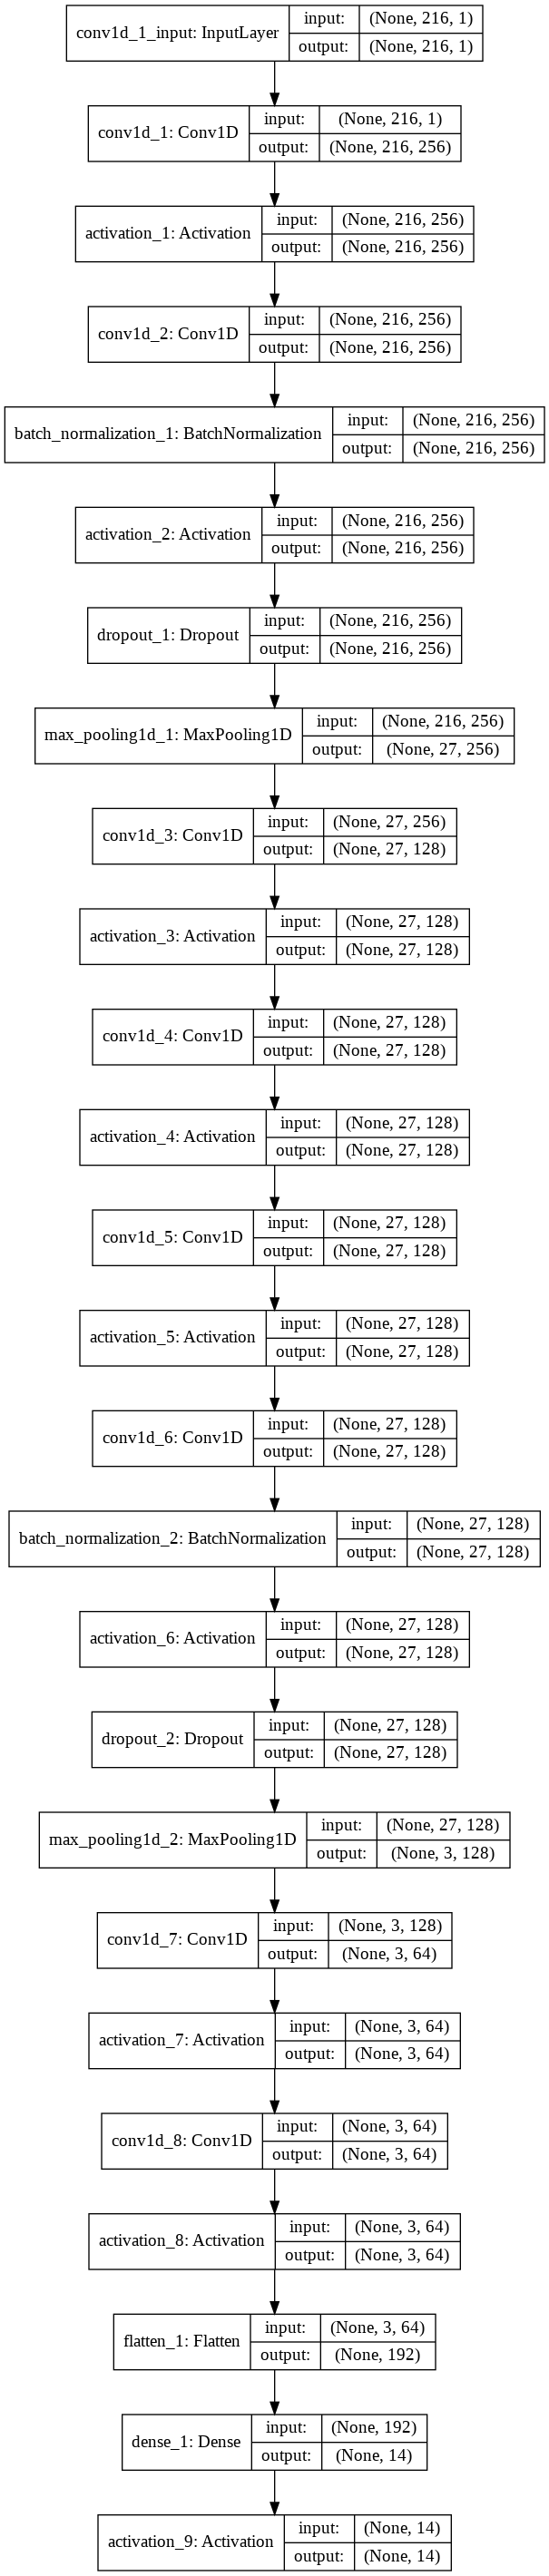

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, dpi = 96)

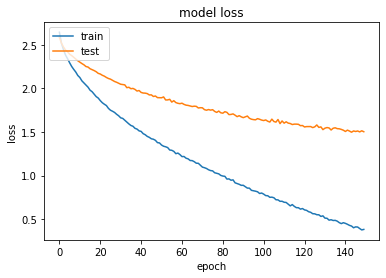

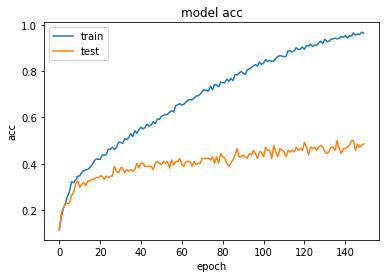

In [0]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Save model and weights
model_name = 'Emotion_Model_V2.h5'
save_dir = os.path.join(os.getcwd(), '/content/drive/My Drive/Google_CoLab/saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/drive/My Drive/Google_CoLab/saved_models/Emotion_Model_V2.h5 


In [0]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Google_CoLab/saved_models/Emotion_Model_V2.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 48.61%


In [0]:
print(max(model_history.history['val_acc'])*100)

50.000000124176346


In [0]:
preds = loaded_model.predict(x_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

144/144 [==============================] - 0s 2ms/step


array([ 9, 11,  4,  1,  7, 13,  4,  5,  3, 12,  2,  6, 11,  2,  0,  5,  7,
        7,  5,  4,  5,  4,  4, 11,  2, 11,  9, 10,  1,  7,  9,  7,  7,  7,
       11, 11,  1, 11,  5, 10,  4, 11,  5,  7, 11, 13,  4, 11,  0,  5,  9,
        6, 12,  0,  4,  4,  5,  6,  9, 13, 11,  0, 13,  6,  5,  6,  5,  9,
        1, 10,  3,  6,  4,  5, 10, 11,  7,  6, 11,  4,  4,  3,  9, 11,  4,
        7,  2,  3, 12,  4,  4,  3,  2, 10,  5, 10, 10, 10,  4, 10,  1,  2,
       10, 13,  7,  6,  5,  1,  9, 11,  3,  3,  1, 11,  2,  7,  8,  8,  7,
        9,  5,  4,  5, 11, 11,  7,  6, 10,  2,  9, 11,  9,  7,  7,  5, 11,
        4, 11,  1,  1,  7, 12,  0,  4])

In [0]:
currentWav = "/content/drive/My Drive/Google_CoLab/00013.wav"
data, sampling_rate = librosa.load(currentWav)
ipd.Audio(currentWav)

In [0]:
#TransformedClassLabels = ['female_angry', 'female_disgust', 'female_fear', 'female_happy',
 #'female_neutral', 'female_sad', 'female_surprise', 'male_angry',
 #'male_disgust', 'male_fear', 'male_happy', 'male_neutral', 'male_sad',
 #'male_surprise']

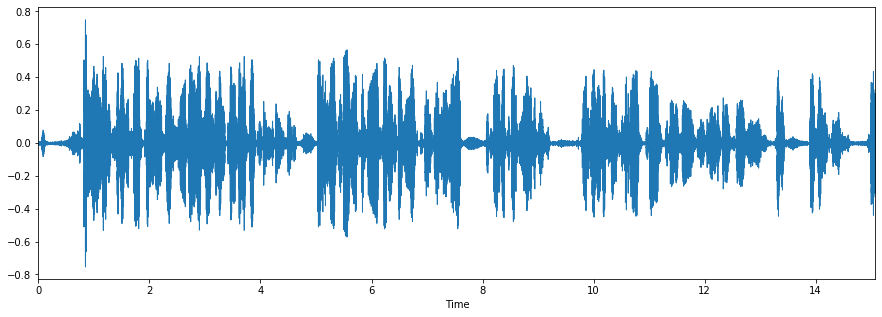

In [0]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [0]:
X, sample_rate = librosa.load(currentWav
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
currentlydf = pd.DataFrame(data=mfccs).T
currentlydf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-22.136263,-19.648015,-18.583185,-17.407681,-20.401114,-19.123438,-17.182127,-16.464836,-16.593267,-17.839215,-17.695023,-16.59818,-17.172716,-16.316004,-16.358969,-19.252232,-17.204235,-17.194567,-17.095944,-15.726101,-16.971049,-17.386895,-18.33738,-20.483701,-20.136695,-17.489939,-9.672431,-5.560102,-5.750314,-4.514117,-4.84979,-6.211656,-9.295344,-11.345024,-12.666124,-12.716383,-12.074889,-11.690677,-12.419024,-12.194441,...,-6.963624,-8.21835,-10.499327,-11.127346,-12.041225,-11.144789,-10.177243,-8.922744,-8.35458,-8.253562,-9.438226,-9.226413,-8.448309,-7.604051,-6.281851,-5.72546,-5.5496,-6.756133,-6.842025,-8.697573,-10.739097,-11.571148,-10.646716,-11.348727,-11.710131,-12.907825,-10.445121,-9.829964,-9.439848,-8.549516,-7.739884,-6.374055,-5.695397,-5.351249,-6.043253,-4.124361,-4.529269,-4.539673,-2.671004,0.772893


In [0]:
currentlydf = np.expand_dims(currentlydf, axis=2)
newestPred = loaded_model.predict(currentlydf, 
                         batch_size=16, 
                         verbose=1)

newestPred

1/1 [==============================] - 0s 15ms/step


array([[3.9279517e-09, 1.1891944e-10, 9.9992812e-01, 4.6069470e-08,
        8.5585796e-09, 7.1796698e-05, 1.1653869e-07, 4.9131012e-13,
        1.4724281e-17, 1.4616011e-15, 2.9022527e-23, 9.2300902e-17,
        3.1140868e-10, 8.7630091e-17]], dtype=float32)

In [0]:
# filename = '/content/drive/My Drive/Google_CoLab/labels'
# infile = open(filename,'rb')
# lb = pickle.load(infile)
# infile.close()

# Get the final predicted label
final = newestPred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #emo(final) #gender(final) 

['female_fear']


#--------------------------#------------------------------

In [0]:

preds = preds.astype(int)
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[:]

print(y_test.argmax(axis=1))
finalY_test = y_test.argmax(axis=1)
predictedClassLabels = []
actualClassLabels = []
for index, i in enumerate(preds['predictedvalues']):
    predictedClassLabels.append(TransformedClassLabels[i])
    actualClassLabels.append(TransformedClassLabels[i])
    
#print(predictedClassLabels)
#print(actualClassLabels)
data = [predictedClassLabels, actualClassLabels]
print(data[0])
print(data[1])
finaldf = pd.DataFrame(data, columns=['Predicted Class Labels', "Actual Class Labels"])

[ 9 11  4  4  7 10  4  2  6 11  6  6 12  2 10  2  0  7  3  1  1  4  4 12
  2 12 13 13  8  7 13  7 10  9 13 11  8  7  3  9  4 11  4  7 13 10  4 11
  0  5 12  6 13  0  4  4  4  6 10 11 13  2 13  6  2  3  4  9  1 10  3  6
  4  5 13 11  7  6 12  1 12  3  6 11  3  7  2  3 10  4  4  3  2  0  4 13
 13 10  4 13  1  9  7  9 10  6  3  1  9 11  6  0  6 11  2  0  8  8  9  9
  1  4  6  8 12  7  6 10  2  2 12 10 10  7  4  7  4 11  1  1  7  0  3 10]


TypeError: ignored

In [0]:
display(finaldf)
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues,predictedvalues
0,male_fear,male_fear
1,male_neutral,male_neutral
2,female_neutral,female_neutral
3,female_neutral,female_neutral
4,male_angry,male_angry
...,...,...
139,female_disgust,female_neutral
140,male_angry,male_angry
141,female_angry,male_sad
142,female_happy,female_disgust


,actualvalues
predictedvalues,
female_angry,10
female_disgust,11
female_fear,4
female_happy,14
female_neutral,21
female_sad,7
female_surprise,5
male_angry,15
male_disgust,5


In [0]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.5


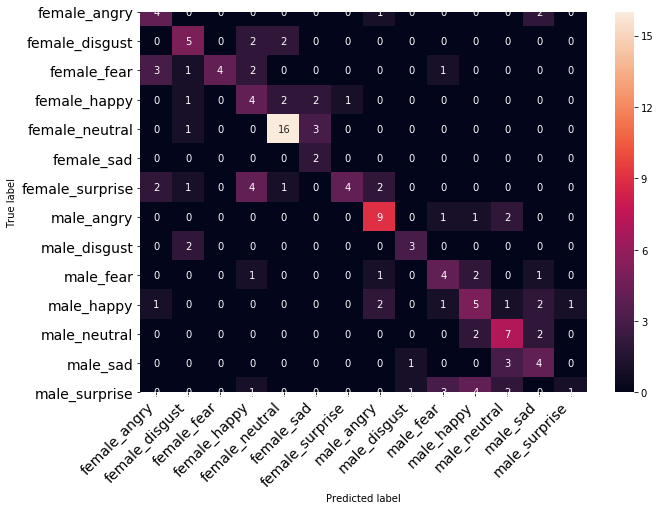

In [0]:
import seaborn as sns
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [0]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.40      0.57      0.47         7
 female_disgust       0.45      0.56      0.50         9
    female_fear       1.00      0.36      0.53        11
   female_happy       0.29      0.40      0.33        10
 female_neutral       0.76      0.80      0.78        20
     female_sad       0.29      1.00      0.44         2
female_surprise       0.80      0.29      0.42        14
     male_angry       0.60      0.69      0.64        13
   male_disgust       0.60      0.60      0.60         5
      male_fear       0.40      0.44      0.42         9
     male_happy       0.36      0.38      0.37        13
   male_neutral       0.47      0.64      0.54        11
       male_sad       0.36      0.50      0.42         8
  male_surprise       0.50      0.08      0.14        12

       accuracy                           0.50       144
      macro avg       0.52      0.52      0.47       144
   weighted avg       0.56   

0.9236111111111112


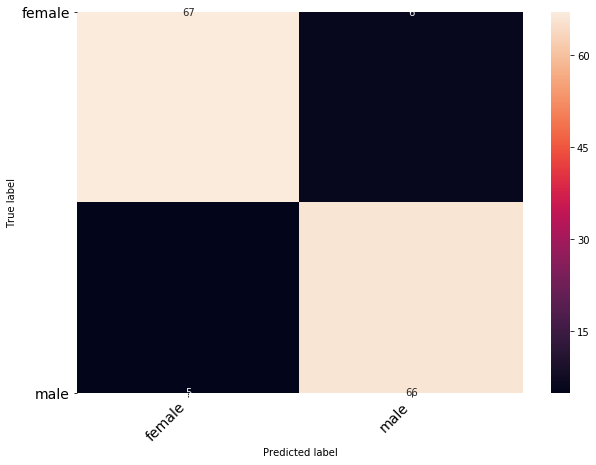

In [0]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [0]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.93      0.92      0.92        73
        male       0.92      0.93      0.92        71

    accuracy                           0.92       144
   macro avg       0.92      0.92      0.92       144
weighted avg       0.92      0.92      0.92       144



0.5277777777777778


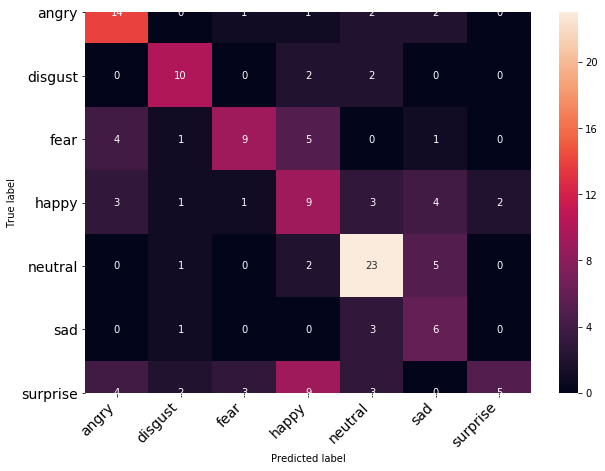

In [0]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [0]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.56      0.70      0.62        20
     disgust       0.62      0.71      0.67        14
        fear       0.64      0.45      0.53        20
       happy       0.32      0.39      0.35        23
     neutral       0.64      0.74      0.69        31
         sad       0.33      0.60      0.43        10
    surprise       0.71      0.19      0.30        26

    accuracy                           0.53       144
   macro avg       0.55      0.54      0.51       144
weighted avg       0.57      0.53      0.51       144

